### Attribute Information
Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv

- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- holiday : weather day is holiday or not
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit :
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import zipfile
import io

# Sklearn model delection
from sklearn.model_selection import RandomizedSearchCV
# Sklearn metrics
from sklearn.metrics import mean_squared_error, mean_squared_log_error
# Sklearn models
from sklearn.linear_model import Lasso, ElasticNet, Ridge, SGDRegressor
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LinearRegression

%matplotlib inline

# Prepare Data
### Load and prepare Bike Sharing dataset

In [3]:
content = requests.get("https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip").content
with zipfile.ZipFile(io.BytesIO(content)) as arc:
    raw_data = pd.read_csv(arc.open("day.csv"), header=0, sep=',', parse_dates=['dteday'])

### Define category features, numeric features and target

In [4]:
category_features = ['season', 'holiday', 'mnth', 'weekday', 'workingday', 'weathersit']
number_features = ['temp', 'atemp', 'hum', 'windspeed']

features= category_features + number_features
target = ['cnt']

### Brief look at the data - check accuracy, fit to real life constraints, distribution.

##### Breef look

In [5]:
raw_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [6]:
raw_data.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [7]:
raw_data[number_features].describe()

,temp,atemp,hum,windspeed
count,731.000000,731.000000,731.000000,731.000000
mean,0.495385,0.474354,0.627894,0.190486
std,0.183051,0.162961,0.142429,0.077498
min,0.059130,0.079070,0.000000,0.022392
25%,0.337083,0.337842,0.520000,0.134950
50%,0.498333,0.486733,0.626667,0.180975
75%,0.655417,0.608602,0.730209,0.233214
max,0.861667,0.840896,0.972500,0.507463


In [8]:
raw_data[category_features].astype('category').describe()

,season,holiday,mnth,weekday,workingday,weathersit
count,731,731,731,731,731,731
unique,4,2,12,7,2,3
top,3,0,1,0,1,1
freq,188,710,62,105,500,463


##### Distribution

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

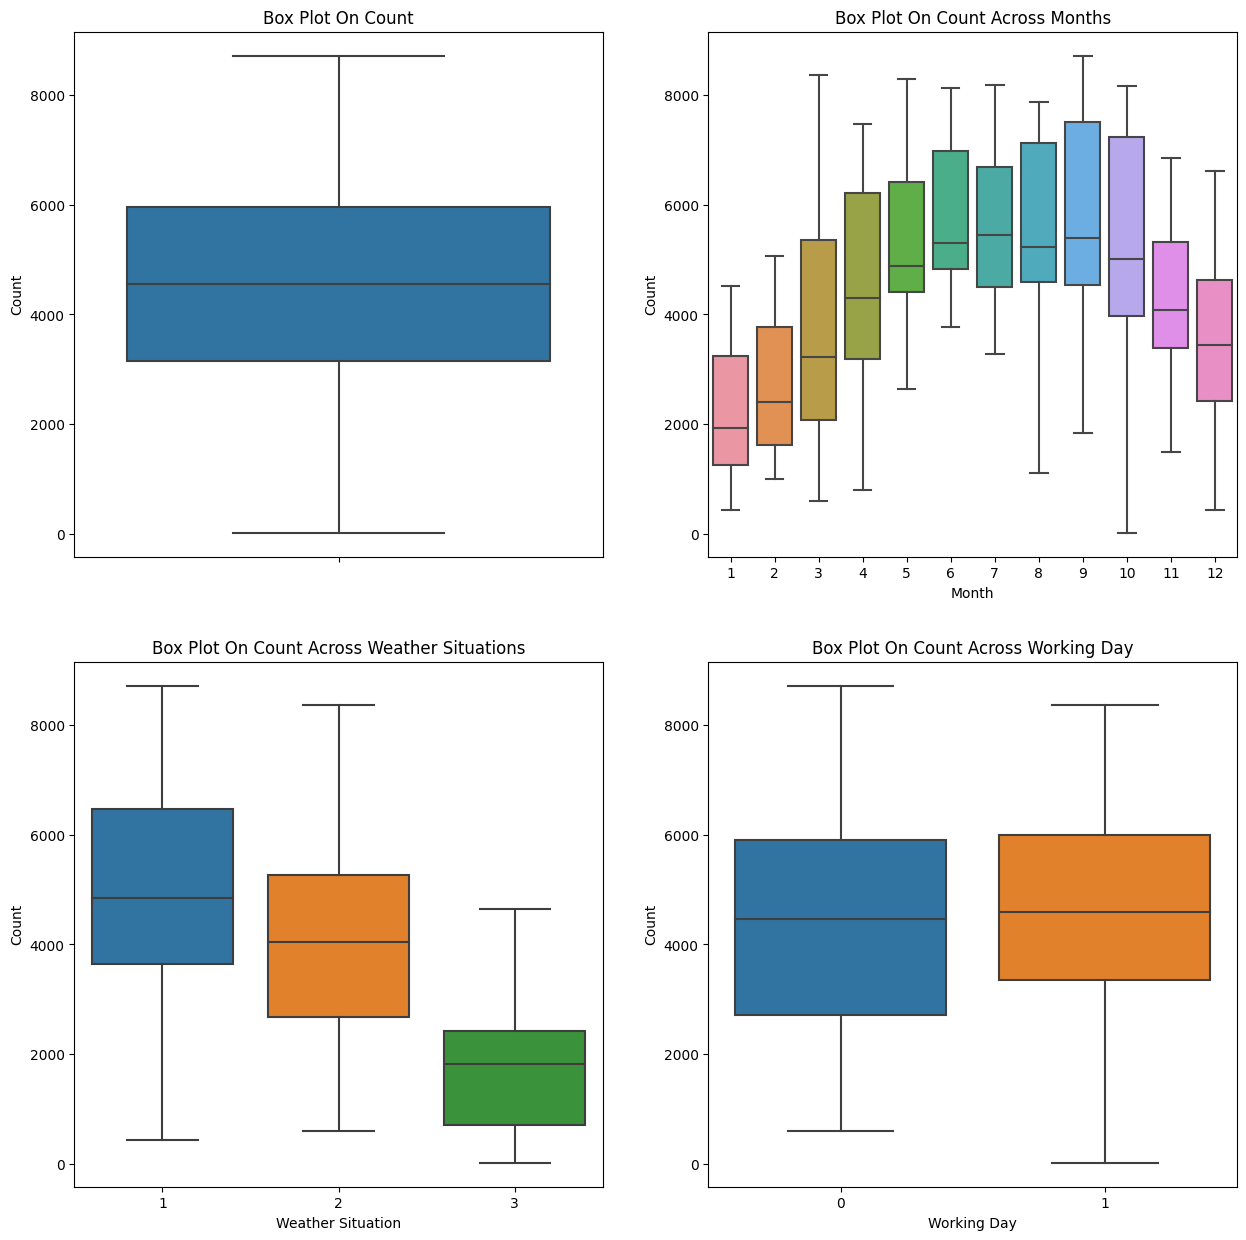

In [9]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(15, 15)

sns.boxplot(data=raw_data,y="cnt",orient="v",ax=axes[0][0])
axes[0][0].set(ylabel='Count',title="Box Plot On Count")

sns.boxplot(data=raw_data,y="cnt",x="mnth",orient="v",ax=axes[0][1])
axes[0][1].set(xlabel='Month', ylabel='Count',title="Box Plot On Count Across Months")

sns.boxplot(data=raw_data,y="cnt",x="weathersit",orient="v",ax=axes[1][0])
axes[1][0].set(xlabel='Weather Situation', ylabel='Count',title="Box Plot On Count Across Weather Situations")

sns.boxplot(data=raw_data,y="cnt",x="workingday",orient="v",ax=axes[1][1])
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")


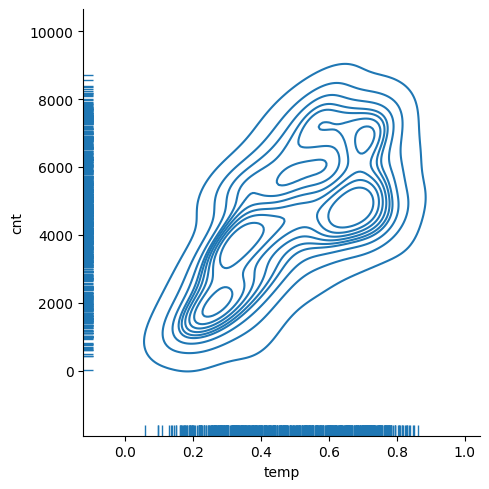

In [21]:

sns.displot(data=raw_data,y="cnt",x="temp", kind="kde", rug=True)

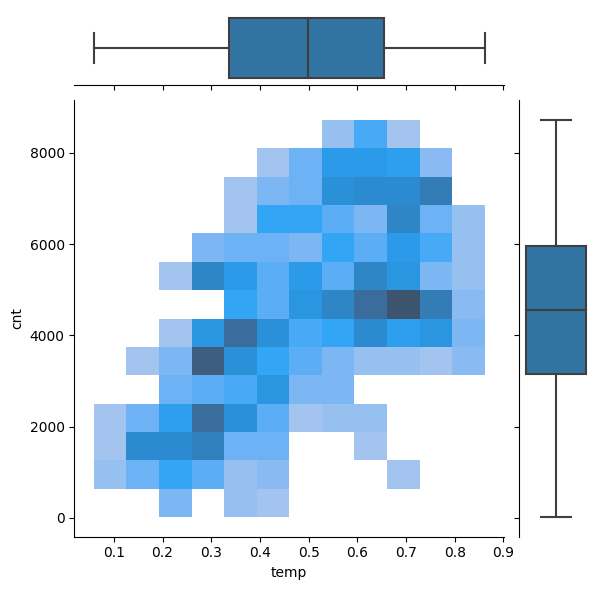

In [17]:
jg = sns.JointGrid(data=raw_data,y="cnt",x="temp")
jg.plot_joint(sns.histplot)
jg.plot_marginals(sns.boxplot)

##### Understanding boxplot

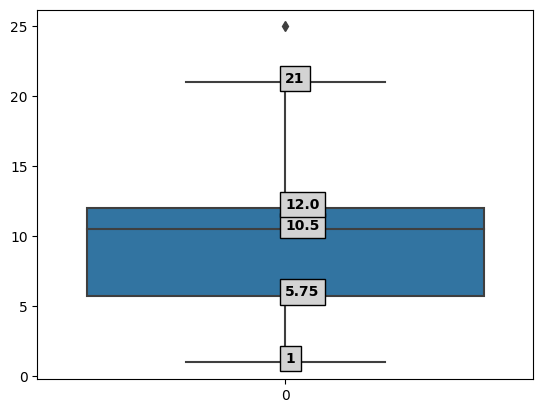

In [79]:
from matplotlib.cbook import boxplot_stats

#x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
x = [1,2,3,4,5,6,7,8,9,10,11,12,12,12,12,12,12,12,21,25]

#extract the boxplot stats
statistics = boxplot_stats(x)
pd_statistics = pd.DataFrame(statistics).iloc[:, [4, 5, 7, 8, 9]].round(2)

bp = sns.boxplot(data=x)
for xtick in bp.get_xticks():
    for col in pd_statistics.columns:
        bp.text(xtick, pd_statistics[col][xtick], pd_statistics[col][xtick], horizontalalignment='left', size='medium', color='k', weight='semibold', bbox=dict(facecolor='lightgray'))

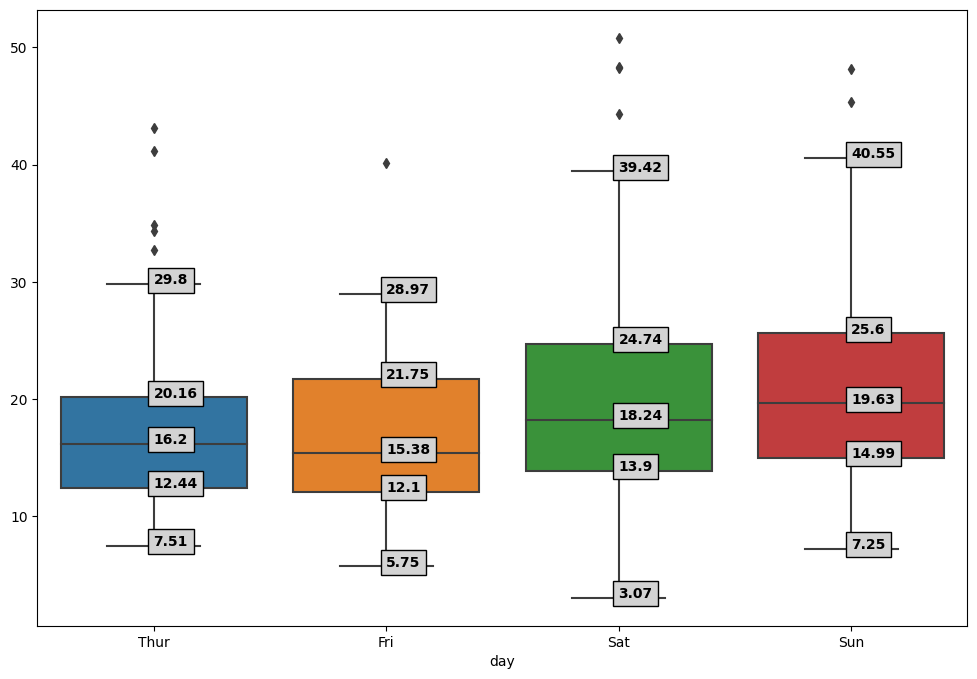

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats

# load sample data
tips = sns.load_dataset("tips")

# 1. pivot tips so there's a column for each day for total_bill
days_total_bill = tips.pivot(columns='day', values='total_bill')
# 2. extract the boxplot stats for each day
days_total_bill_stats = [boxplot_stats(days_total_bill[col].dropna().values)[0] for col in days_total_bill.columns]
# 3. create a dataframe for the stats for each day
stats = pd.DataFrame(days_total_bill_stats, index=days_total_bill.columns).iloc[:, [4, 5, 7, 8, 9]].round(2)

# plot
fig, ax = plt.subplots(figsize=(12, 8))
# directly plot the wide dataframe with only the total_bill data
box_plot = sns.boxplot(data=days_total_bill, ax=ax)

# same plot is created with the primary tips dataframe
# box_plot = sns.boxplot(x="day", y="total_bill", data=tips, ax=ax)

# annotate
for xtick in box_plot.get_xticks():
    for col in stats.columns:
        box_plot.text(xtick, stats[col][xtick], stats[col][xtick], horizontalalignment='left', size='medium', color='k', weight='semibold', bbox=dict(facecolor='lightgray'))

### Missing values - check completeness

In [11]:
print(raw_data.isnull().any())

instant       False
dteday        False
season        False
yr            False
mnth          False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
dtype: bool


### Correlations - check consistensy and uniqueness

<Axes: >

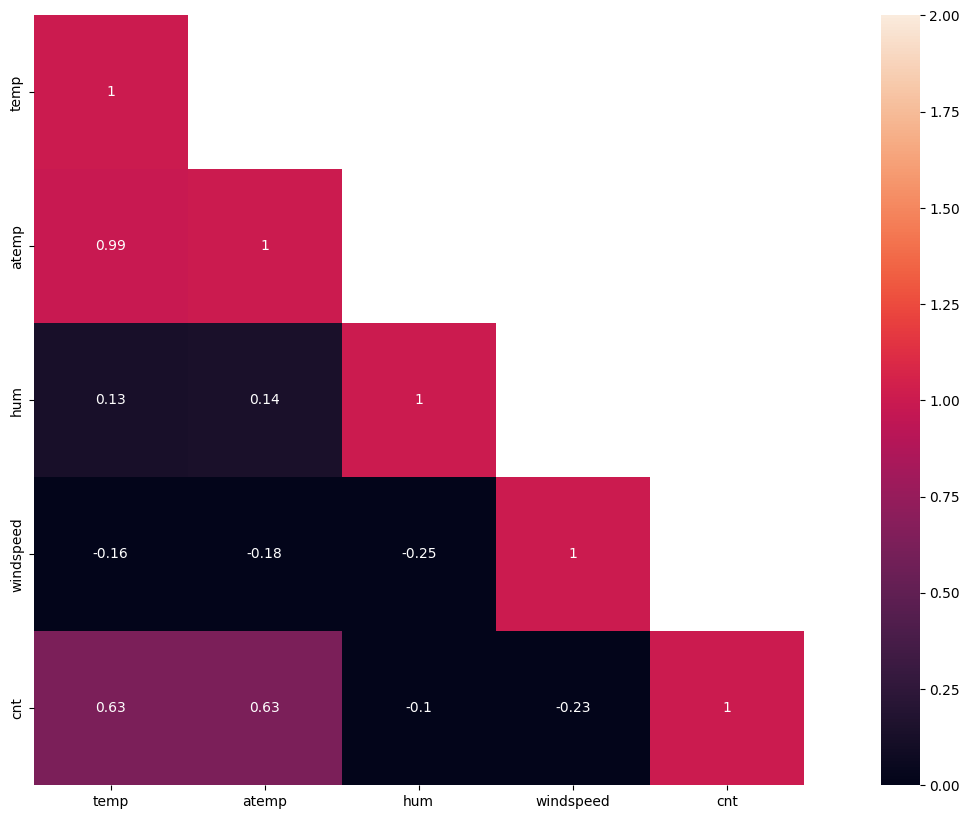

In [104]:
#Calculate correlations
correlations = raw_data[number_features + target].corr()

#Cut upper right half of the field, as there are only duplications.
heat = np.array(correlations)
heat[np.tril_indices_from(heat)] = False

#Draw the plot
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(correlations, mask=heat, square=True, annot=True, vmin=0.0, vmax=2.0)